In [3]:
# Import Packages for project

# Standard Libraries
import csv
import cv2
import imageio
from IPython.display import Image
import glob
import numpy as np
import os
import pandas as pd
import re
import utils

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Algorithms, Modeling and Data Pre-processing
import feature_engine
from feature_engine.encoding import OrdinalEncoder
from feature_engine.transformation import YeoJohnsonTransformer
from scipy.stats import anderson, chi2_contingency
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,precision_score, roc_auc_score,recall_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Deep Learning
import keras
from keras import layers
from keras.layers import RandomFlip, RandomRotation, Rescaling, BatchNormalization, Conv2D, MaxPooling2D, Dense, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model Optimization and Hyperparameter Tuning
import hyperopt
from hyperopt import STATUS_OK, Trials, fmin, tpe, hp
import mlflow

import tensorboard

In [4]:
# Obtain the Data
filepath = '../data/K400/video_annotations.csv'
raw_csv = pd.read_csv(filepath)
k400_df = pd.DataFrame(raw_csv)

k400_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19906 entries, 0 to 19905
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   label       19906 non-null  object 
 1   youtube_id  19906 non-null  object 
 2   video_name  0 non-null      float64
 3   time_start  19906 non-null  int64  
 4   time_end    19906 non-null  int64  
 5   split       19906 non-null  object 
 6   is_cc       19906 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 4.4 MB


In [5]:
# initial inspection of complete dataframe
k400_df.head

<bound method NDFrame.head of            label   youtube_id  video_name  time_start  time_end split  is_cc
0      abseiling  0wR5jVB-WPk         NaN         417       427   val      0
1      abseiling  3caPS4FHFF8         NaN          36        46   val      0
2      abseiling  3yaoNwz99xM         NaN          62        72   val      1
3      abseiling  6IbvOJxXnOo         NaN          47        57   val      0
4      abseiling  6_4kjPiQr7w         NaN         191       201   val      0
...          ...          ...         ...         ...       ...   ...    ...
19901      zumba  w5hbJLVhZDI         NaN          93       103   val      0
19902      zumba  xDd6uIBeMEA         NaN           1        11   val      0
19903      zumba  XWvGn7eI04A         NaN          12        22   val      0
19904      zumba  yGdQwxP5koA         NaN          83        93   val      0
19905      zumba  ZVDR2od1gn8         NaN          37        47   val      0

[19906 rows x 7 columns]>

In [6]:
# Check for null values/percentage of null values:

k400_df.isna().mean()

label         0.0
youtube_id    0.0
video_name    1.0
time_start    0.0
time_end      0.0
split         0.0
is_cc         0.0
dtype: float64

In [7]:
k400_df.isna().sum()

label             0
youtube_id        0
video_name    19906
time_start        0
time_end          0
split             0
is_cc             0
dtype: int64

### Observations 

1. No null values
2. Over 240k Observations
3. 6 Attributes of string/int datatypes

In [8]:
# check for dup
num_unique = k400_df.nunique()
num_unique

label           400
youtube_id    19512
video_name        0
time_start      842
time_end        842
split             1
is_cc             2
dtype: int64

### Observations

1. THere are 400 unique labels
2. There are about 20K youtube_id with only about 850 videos
3. Videos duration is only 10 seconds as annotated by the difference between time_start and time_end values

**Next Steps**: to reduce the dimensionality, I need to create a function that will map a video file to a youtube id value in the video_annotations.csv file and create a new dataframe where we have a match. Data Cleaning required on the names of the video files

In [9]:
youtube_id_values = k400_df['youtube_id']
print(f"Total Youtube ID Values in Dataset: {youtube_id_values.count()}")

Total Youtube ID Values in Dataset: 19906


In [10]:
# Get the amount of unique youtube_id
number_unique_id = youtube_id_values.nunique()
print(f"Unique Youtube ID Values: {number_unique_id}")

Unique Youtube ID Values: 19512


In [11]:
# Check for unique values
unique_youtube_id = youtube_id_values.unique()
unique_youtube_id

array(['0wR5jVB-WPk', '3caPS4FHFF8', '3yaoNwz99xM', ..., 'XWvGn7eI04A',
       'yGdQwxP5koA', 'ZVDR2od1gn8'], dtype=object)

In [12]:
# Get the number of video files we are working with
def count_video_files(directory):
    """
    Purpose - to get a video file count within a given directory
    Arguments - directory variable that holds the filepath to a video directory
    Returns - video_count of type integer
    
    """
    # Set the allowed video file extensions
    video_extensions = ['.mp4', '.avi', '.mov', '.mkv', '.wmv', '.flv']

    # Initialize the count
    video_count = 0

    # Iterate through all files in the directory
    for file_path in glob.glob(os.path.join(directory, '*')):
        # Check if the file has a video file extension
        if os.path.isfile(file_path) and any(file_path.lower().endswith(ext) for ext in video_extensions):
            video_count += 1

    return video_count


In [13]:
# Test Functionality and return video count

# Provide the directory path to count video files
directory_path = '../data/K400/videos'

# Call the function to count video files
num_videos = count_video_files(directory_path)
print(f'Total number of video files: {num_videos} videos present')

Total number of video files: 1137 videos present


### Video Observations

1. There seems to be a match with the youtube_id values in the video_annotations.csv file and the initial naming convention of the video files.
2. The videofile names have a timestamp that highlights how the 10second video frame was captured. 

**Next Steps**: In order to load in local video data correctly, I need to perform regular expressions to rename the video files to exclude the timestamps.

## Exploratory Data Analysis: Labels

For this project, we will explore what labels are present in the Kinetic 400 dataset

In [14]:
k400_labels = k400_df['label']
k400_labels.tail(10)

19896    zumba
19897    zumba
19898    zumba
19899    zumba
19900    zumba
19901    zumba
19902    zumba
19903    zumba
19904    zumba
19905    zumba
Name: label, dtype: object

In [15]:
unique_labels = k400_labels.unique()
unique_labels

array(['abseiling', 'air drumming', 'answering questions', 'applauding',
       'applying cream', 'archery', 'arm wrestling', 'arranging flowers',
       'assembling computer', 'auctioning', 'baby waking up',
       'baking cookies', 'balloon blowing', 'bandaging', 'barbequing',
       'bartending', 'beatboxing', 'bee keeping', 'belly dancing',
       'bench pressing', 'bending back', 'bending metal',
       'biking through snow', 'blasting sand', 'blowing glass',
       'blowing leaves', 'blowing nose', 'blowing out candles',
       'bobsledding', 'bookbinding', 'bouncing on trampoline', 'bowling',
       'braiding hair', 'breading or breadcrumbing', 'breakdancing',
       'brush painting', 'brushing hair', 'brushing teeth',
       'building cabinet', 'building shed', 'bungee jumping', 'busking',
       'canoeing or kayaking', 'capoeira', 'carrying baby',
       'cartwheeling', 'carving pumpkin', 'catching fish',
       'catching or throwing baseball', 'catching or throwing frisbee',


### Visualize the top 50 labels in the k400 dataset

C:\Users\638545\AppData\Local\Temp\ipykernel_32836\878770327.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_20_labels.index, x=top_20_labels.values, palette='viridis')


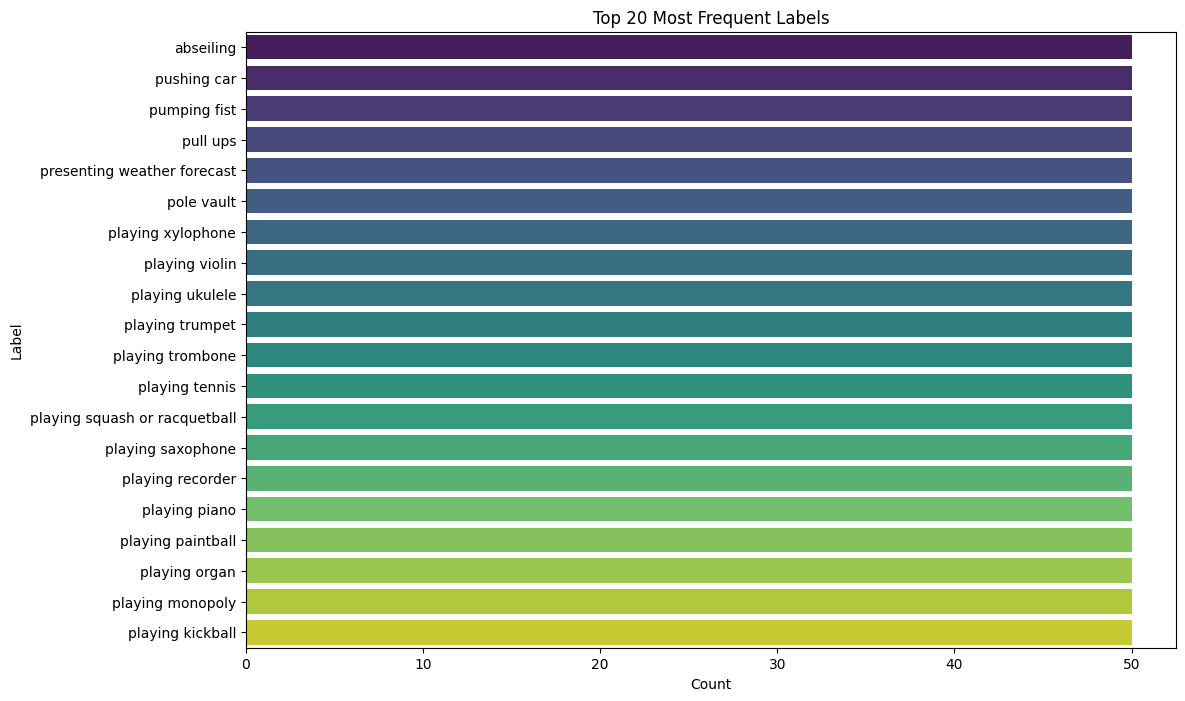

In [16]:
# Count occurrences of each label
label_counts = k400_labels.value_counts()

# Select the top 10 labels
top_20_labels = label_counts.head(20)

# Create a countplot for the top 10 labels using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(y=top_20_labels.index, x=top_20_labels.values, palette='viridis')

# Customize plot
plt.title('Top 20 Most Frequent Labels')
plt.xlabel('Count')
plt.ylabel('Label')

# Show plot
plt.show()

### Observations

The most frequent label in the dataset is 'abseiling', which has a count close to 50. This suggests that videos of abseiling are very common in the dataset.

The activities can be categorized into several groups:

**Musical activities**: These include playing instruments like the violin, ukulele, trumpet, trombone, saxophone, recorder, piano, and organ. We can see that musical activities feature prominently in the dataset, indicating a possible focus on musical performance videos.

**Sports and physical activities**: This group includes pole vault, playing tennis, squash or racquetball, and kickball, among others. These activities are likely to involve dynamic movement, which can be useful for training algorithms to recognize physical actions.

**Recreational games**: Playing Monopoly is included, which is an indoor recreational game. This may suggest that tehre are other labels in the dataset that may represent indoor activities where movement may be minimal

### Data Preprocessing - Rename video file names for easier loading

Purpose - This step is required in order to extract features and data from the raw video files from the Kinetic Dataset. This will help later on when we split our data to feed into our future model.

In [17]:
def remove_timestamp(filename):
    """
    Purpose: to remove the timestampe suffix at the end of our local video files
    Arguments: filename 
    Retunrs: Cleaned filename
    """
    # Split the filename by underscores
    parts = filename.rsplit('_')

    # Filter out parts that are likely numbers
    cleaned_parts = [part for part in parts if not part.isdigit()]

    # Join the cleaned parts with underscores to form the new filename
    cleaned_filename = '_'.join(cleaned_parts)

    return cleaned_filename # Remove leading/trailing whitespaces


In [18]:
def rename_files(directory):
    """
    Purpose: To rename all the local video files in our directory for future loading 
    Arguments: Filepath to the video directory
    Returns: None

    Other Functions: Calls the remove_timestamp()
    """
    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        # Check if the file is a regular file (not a directory)
        if os.path.isfile(os.path.join(directory, filename)):
            # Remove timestamp from the filename
            new_filename = remove_timestamp(filename)
            # Rename the file if the filename has changed
            if new_filename != filename:
                os.rename(os.path.join(directory, filename),
                          os.path.join(directory, new_filename))

In [19]:
# Test
video_directory = "../data/K400/videos"

rename_files(video_directory)

In [20]:
video_directory = '../data/K400/videos'

# Iterate through each YouTube ID
for youtube_id in youtube_id_values:
    # Find the corresponding video file in the directory
    for filename in os.listdir(video_directory):
        if youtube_id in filename:
            # Extract the file extension
            file_extension = os.path.splitext(filename)[1]

            # Construct the new file name without the timestamp
            new_filename = youtube_id + file_extension

            # Construct the full paths for old and new files
            old_filepath = os.path.join(video_directory, filename)
            new_filepath = os.path.join(video_directory, new_filename)

            # Rename the file
            os.rename(old_filepath, new_filepath)
            print(f'Renamed {filename} to {new_filename}')
            break

Renamed 0wR5jVB-WPk.mp4 to 0wR5jVB-WPk.mp4
Renamed VbQLp-cqHAA_000112.mp4 to VbQLp-cqHAA.mp4
Renamed 0htNc0u9TDk_000010.mp4 to 0htNc0u9TDk.mp4
Renamed 1438aE9LMgY_000065.mp4 to 1438aE9LMgY.mp4
Renamed -r8c7F4tOI8_000064.mp4 to -r8c7F4tOI8.mp4
Renamed 0CLLZNQN9aI_000042.mp4 to 0CLLZNQN9aI.mp4
Renamed 0cONsRVrLbU_000033.mp4 to 0cONsRVrLbU.mp4
Renamed 0S-P4lr_c7s_000032.mp4 to 0S-P4lr_c7s.mp4
Renamed -10xhPhBo0k_000508.mp4 to -10xhPhBo0k.mp4
Renamed -4hx9N2OhZo_000039.mp4 to -4hx9N2OhZo.mp4
Renamed 04jTKnOYrZw_000086.mp4 to 04jTKnOYrZw.mp4
Renamed -C6BDDvJO4A_000055.mp4 to -C6BDDvJO4A.mp4
Renamed 0Cegwffz0Ck_000497.mp4 to 0Cegwffz0Ck.mp4
Renamed WKNa4ZL3raA_000077.mp4 to WKNa4ZL3raA.mp4
Renamed -0OK3nbLKgM_000022.mp4 to -0OK3nbLKgM.mp4
Renamed -1DQLnNEH8g_000013.mp4 to -1DQLnNEH8g.mp4
Renamed X66nHKtYtt0_000018.mp4 to X66nHKtYtt0.mp4
Renamed -514AQUrSow_000068.mp4 to -514AQUrSow.mp4
Renamed 06HBsMpx9SM_000022.mp4 to 06HBsMpx9SM.mp4
Renamed VzrtqwlLyI8_000048.mp4 to VzrtqwlLyI8.mp4
Renamed

### Observations

Removed the start_time portion of the timestamp, but left the end_time timestamp in the video file name

### Define Hyperparameters

In [21]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

### Data Preparation

In [22]:
split_percent = .30

# Split the k400_df into test and train df

# Split the dataframe into train and test using pd.sample()
test_df = k400_df.sample(frac=split_percent, random_state=42)
train_df = k400_df.drop(test_df.index)

# Reset the index of the new dataframes
test_df.reset_index(drop=True, inplace=True)
train_df.reset_index(drop=True, inplace=True)

In [23]:
len(test_df)

5972

In [24]:
len(train_df)

13934

### Notes

train_df has 13934 Rows with 6 Attributes

test_df has 5972 rows

In [25]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [26]:
def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [27]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [28]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["label"])
)
print(label_processor.get_vocabulary())


['abseiling', 'air drumming', 'answering questions', 'applauding', 'applying cream', 'archery', 'arm wrestling', 'arranging flowers', 'assembling computer', 'auctioning', 'baby waking up', 'baking cookies', 'balloon blowing', 'bandaging', 'barbequing', 'bartending', 'beatboxing', 'bee keeping', 'belly dancing', 'bench pressing', 'bending back', 'bending metal', 'biking through snow', 'blasting sand', 'blowing glass', 'blowing leaves', 'blowing nose', 'blowing out candles', 'bobsledding', 'bookbinding', 'bouncing on trampoline', 'bowling', 'braiding hair', 'breading or breadcrumbing', 'breakdancing', 'brush painting', 'brushing hair', 'brushing teeth', 'building cabinet', 'building shed', 'bungee jumping', 'busking', 'canoeing or kayaking', 'capoeira', 'carrying baby', 'cartwheeling', 'carving pumpkin', 'catching fish', 'catching or throwing baseball', 'catching or throwing frisbee', 'catching or throwing softball', 'celebrating', 'changing oil', 'changing wheel', 'checking tires', 'che

In [29]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["youtube_id"].values.tolist()
    labels = df["label"].values
    labels = keras.ops.convert_to_numpy(label_processor(labels[..., None]))

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(
            shape=(
                1,
                MAX_SEQ_LENGTH,
            ),
            dtype="bool",
        )
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :], verbose=0,
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

In [30]:
# Test functionality
train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

In [31]:
print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (13934, 20, 2048)
Frame masks in train set: (13934, 20)
